In [ ]:
!pip install transformers
!pip install shap
!pip install spicy

In [ ]:
import transformers
import shap
import spicy as sp
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.utils import data
from sklearn import metrics
import torch.nn as nn
import pandas as pd
import numpy as np
import argparse
import logging
import random
import torch
import sys
import os

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
PREDICTION_COLUMN = 'Экстраверсия_3'
model_path = '/content/drive/MyDrive/big_5/OCEAN_shap_texts_bert/simple_bert_Экстраверсия_3_80222.bin'

dataset = pd.read_csv('/content/drive/MyDrive/big_5/df_texts_ocean.csv')
dataset['lengths'] = dataset.post_text.apply(lambda x: len(str(x).split()))
dataset = dataset.query('30 > lengths > 15')
data = pd.DataFrame({'text_raw':dataset['post_text'],'text':dataset['post_text_preprocessed'],'target':dataset[PREDICTION_COLUMN]})
#data = data.query('target in [0,2]').sample(5000)
_,data = train_test_split(data, test_size=0.3, stratify=data.target)
data

,text_raw,text,target
128872,"О чем скорбеть? Клянусь дыханьем, есть в жизни...",о чем скорбеть PUNK клянусь дыханьем PUNK есть...,0
66059,"Полина, МиниТест « как ты назовешь своего реб...",полина PUNK минитест PUNK как ты назовешь свое...,0
13035,"ПОЗДРАВЛЯЮ!!!! ☀ Чтоб ты и твоя команда, ПРОЦВ...",поздравляю PUNK PUNK PUNK PUNK EMOJI чтоб ты и...,1
91814,Я организовала экспедицию для помощи дракону! ...,я организовала экспедицию для помощи дракону P...,2
233924,"Какое счастье быть собой! Не притворяться, не...",какое счастье быть собой PUNK не притворяться ...,2
...,...,...,...
218845,"""Ты - то, что ты ешь"" (С). Знакомьтесь, мидии ...",ты PUNK то PUNK что ты ешь PUNK с PUNK PUNK з...,2
201233,"С Днем Рождения,Катюша!!!! Ты замечательный че...",с днем рождения PUNK катюша PUNK PUNK PUNK PUN...,1
238432,Зима близко! А в это время миллионы игроков уж...,зима близко PUNK а в это время миллионы игроко...,2
98071,У тебя есть новые гости! Про тебя есть новые ...,у тебя есть новые гости PUNK про тебя есть нов...,1


In [ ]:
data.target.value_counts()

0    3212
2    2080
1    1627
Name: target, dtype: int64

In [ ]:
len(data)

6919

In [ ]:
frames = []
classes = data.target.unique()

for i in classes:
    g = data[data.target == i].sample(1500)
    frames.append(g)

equally_sampled = pd.concat(frames)

In [ ]:
equally_sampled

,text_raw,text,target
156112,"Привет!Пожалуйста, зайди в игру ""Интерны: 3 в ...",привет PUNK пожалуйста PUNK зайди в игру интер...,0
147041,"Мой результат доп.теста ""Основной вопрос филос...",мой результат доп PUNK теста основной вопрос ф...,0
102633,Пиздравляю с первым выбором)))))))))))))))))И ...,пиздравляю с первым выбором EMOJI PUNK и че ду...,0
132729,Vega Squadron зарегистрировала состав с UnderS...,vega squadron зарегистрировала состав с unders...,0
86326,Люблю Питер. Замечательный город и все вокруг ...,люблю питер PUNK замечательный город и все вок...,0
...,...,...,...
235404,"Это прекрасное чувство, когда встречаешь челов...",это прекрасное чувство PUNK когда встречаешь ч...,2
163350,"Ну что, поздравляю с очередным днем рождения! ...",ну что PUNK поздравляю с очередным днем рожден...,2
59904,хорошь бакланить! всем дрожать и готовиться к ...,хорошь бакланить PUNK всем дрожать и готовитьс...,2
80483,"Узнай, что думают о тебе друзья!О тебе есть но...",узнай PUNK что думают о тебе друзья PUNK о теб...,2


In [ ]:
class Bert_sequence_classifcation(nn.Module):
    def __init__(self, model_name, num_classes):
        super(Bert_sequence_classifcation, self).__init__()
        self.bert = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=num_classes)

    def forward(self, input_ids, attention_mask):
        # Feed input to BERT
        logits = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask, return_dict=True).logits 
        return logits

In [ ]:
 # load the model and tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained('xlm-roberta-base')
model = Bert_sequence_classifcation('xlm-roberta-base', 3).to(device)
model.load_state_dict(torch.load(model_path))   #,map_location=torch.device('cpu')))
labels = sorted(model.bert.config.label2id, key=model.bert.config.label2id.get)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
def f(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    outputs = torch.log_softmax(outputs, dim=1).numpy()
    # print(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

In [ ]:
def predict(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding='max_length', max_length=100, truncation=True) for v in x], device=device)
    # print(tv)
    attention_mask = (tv != 0).type(torch.int64).to(device)
    # print(attention_mask)
    outputs = model(tv, attention_mask).detach().cpu()
    res = torch.log_softmax(outputs, dim=1).argmax(dim=1)
    return res

In [ ]:
predict(['приветик','еще раз привет'])

tensor([2, 2])

In [ ]:
data = equally_sampled

In [ ]:
texts = list(data.text)
targets = list(data.target)

def chunkify(texts, targets, n):

  texts_splited = [texts[i::n] for i in range(n)]
  targets_splited = [targets[i::n] for i in range(n)]

  return texts_splited, targets_splited

texts_splited, targets_splited =chunkify(texts, targets, 100)

In [ ]:
len(texts_splited[0])

45

In [ ]:
from tqdm.auto import tqdm

In [ ]:
predictions = []
for text in tqdm(texts_splited):
  predictions.append(predict(text))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
list_predictions = []
for i in predictions:
  for x in list(i):
    list_predictions.append(int(x))

In [ ]:
len(list_predictions)

4500

In [ ]:
data['predictions'] = list_predictions
data.head()

,text_raw,text,target,predictions
156112,"Привет!Пожалуйста, зайди в игру ""Интерны: 3 в ...",привет PUNK пожалуйста PUNK зайди в игру интер...,0,1
147041,"Мой результат доп.теста ""Основной вопрос филос...",мой результат доп PUNK теста основной вопрос ф...,0,2
102633,Пиздравляю с первым выбором)))))))))))))))))И ...,пиздравляю с первым выбором EMOJI PUNK и че ду...,0,0
132729,Vega Squadron зарегистрировала состав с UnderS...,vega squadron зарегистрировала состав с unders...,0,2
86326,Люблю Питер. Замечательный город и все вокруг ...,люблю питер PUNK замечательный город и все вок...,0,0


In [ ]:
polar_people = data.query('target == predictions')
polar_people

,text_raw,text,target,predictions
102633,Пиздравляю с первым выбором)))))))))))))))))И ...,пиздравляю с первым выбором EMOJI PUNK и че ду...,0,0
86326,Люблю Питер. Замечательный город и все вокруг ...,люблю питер PUNK замечательный город и все вок...,0,0
85073,02.06.18 клуб-Magic вход 100 руб. начало в 19:...,NUM PUNK NUM PUNK NUM клуб PUNK magic вход NU...,0,0
131410,Фотосессия одного котенка от фотографа Бена То...,фотосессия одного котенка от фотографа бена то...,0,0
33064,"Пока ребята вчера вновь ездили кататься, а я с...",пока ребята вчера вновь ездили кататься PUNK а...,0,0
...,...,...,...,...
20234,ахах)))я сейчас с Кириллом гули идууу в центре...,ахах EMOJI PUNK я сейчас с кириллом гули идууу...,2,2
129281,"Привет!Пожалуйста, зайди в игру ""Интерны: 3 в ...",привет PUNK пожалуйста PUNK зайди в игру интер...,2,2
157959,А чем еще заниматься на выходных? Пить какао с...,а чем еще заниматься на выходных PUNK пить как...,2,2
163350,"Ну что, поздравляю с очередным днем рождения! ...",ну что PUNK поздравляю с очередным днем рожден...,2,2


In [ ]:
polar_people.target.value_counts()

2    786
1    461
0    263
Name: target, dtype: int64

In [ ]:
polar_people = polar_people.sort_values(by=['target'])
polar_people

,text_raw,text,target,predictions
102633,Пиздравляю с первым выбором)))))))))))))))))И ...,пиздравляю с первым выбором EMOJI PUNK и че ду...,0,0
184378,Твой парус ласкает взор На нём по волнам я пой...,твой парус ласкает взор на нём по волнам я пой...,0,0
178659,"Мне нужно: Ножовка. Отправь мне Ножовка, а я в...",мне нужно PUNK ножовка PUNK отправь мне ножовк...,0,0
141956,Интервью с VPBenQ|Neytpoh @ 300 APM » Cyber Iv...,интервью с vpbenq PUNK neytpoh PUNK NUM apm PU...,0,0
65357,Поздравляю тебя и желаю тебе главного-исполнен...,поздравляю тебя и желаю тебе главного PUNK исп...,0,0
...,...,...,...,...
18110,10 ТУР!!!!!!!Зенит-Локомотив 2-1 (Халк-2-Кайсе...,NUM тур PUNK PUNK PUNK PUNK PUNK PUNK PUNK зе...,2,2
58212,"Неделя на травме, колено ноет и ноет, но удало...",неделя на травме PUNK колено ноет и ноет PUNK ...,2,2
129875,оставайтесь всегда неотразимой с интернет мага...,оставайтесь всегда неотразимой с интернет мага...,2,2
113157,Почему тюльпаны не цветут у нас круглый год! С...,почему тюльпаны не цветут у нас круглый год PU...,2,2


In [ ]:
s = 'новым годом с наступающим год лошади'
for i, row in polar_people.iterrows():
  if s in row.text:
    print(row)

text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target                                                         0
predictions                                                    0
Name: 100188, dtype: object
text_raw       С Новым годом С наступающим Год лошади 2014 По...
text           с новым годом с наступающим год лошади NUM поз...
target                                                         2
predictions                                                    2
Name: 246029, dtype: object


In [ ]:
import shap
explainer = shap.Explainer(f, tokenizer, output_names=labels)

In [ ]:
texts = list(polar_people.text)
shap_values = explainer(texts)

Partition explainer:  70%|███████   | 1060/1510 [55:45<23:37,  3.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

Partition explainer: 1511it [1:19:46,  3.17s/it]


In [52]:
shap.plots.text(shap_values[:10]) # низкий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.plots.text(shap_values[10:20]) # низкий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.plots.text(shap_values[20:30]) # низкий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
shap.plots.text(shap_values[30:40]) # низкий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [55]:
shap.plots.text(shap_values[-10:]) # высокий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [56]:
shap.plots.text(shap_values[-20:-10]) # высокий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

In [57]:
shap.plots.text(shap_values[-30:-20]) # высокий уровень по шкале

Output hidden; open in https://colab.research.google.com to view.

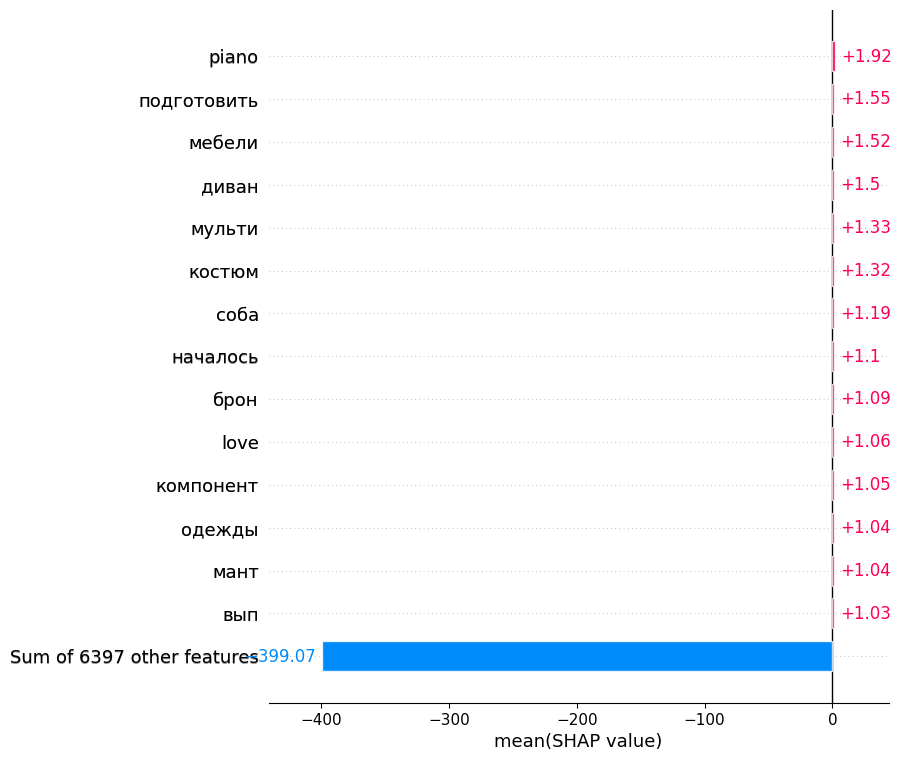

In [ ]:

shap.plots.bar(shap_values[:,:, 2].mean(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

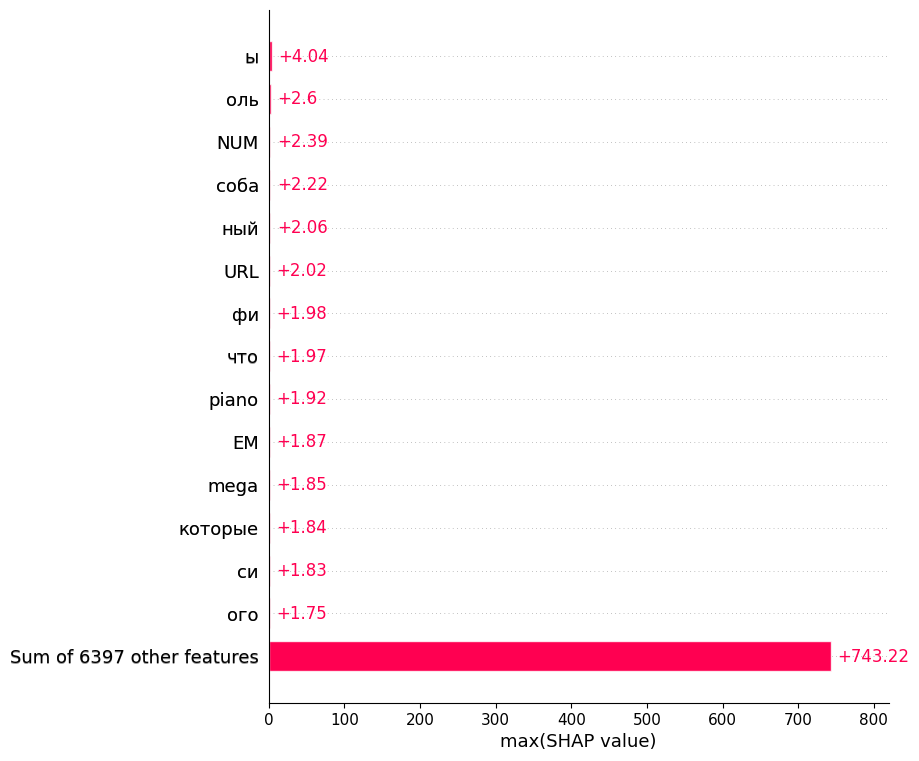

In [ ]:

shap.plots.bar(shap_values[:,:, 2].max(axis=0), max_display=15,
               order=shap.Explanation.argsort.flip)

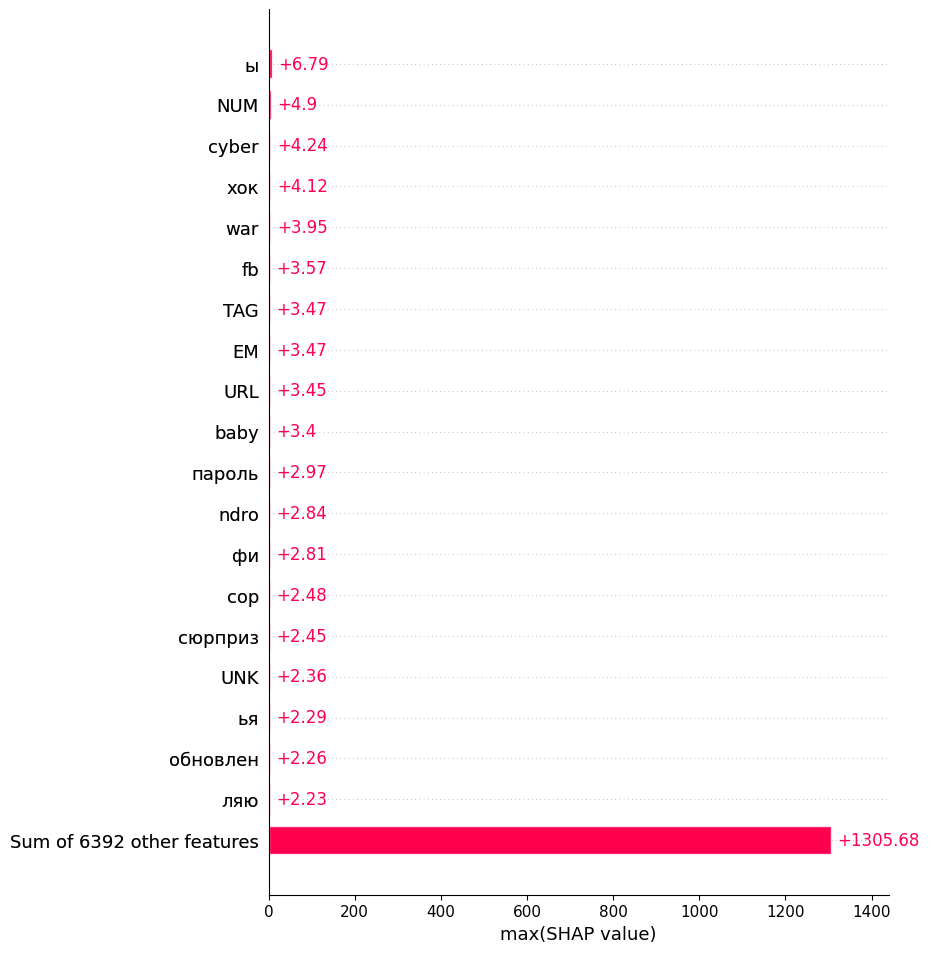

In [ ]:

shap.plots.bar(shap_values[:,:, 0].max(axis=0), max_display=20,
               order=shap.Explanation.argsort.flip)

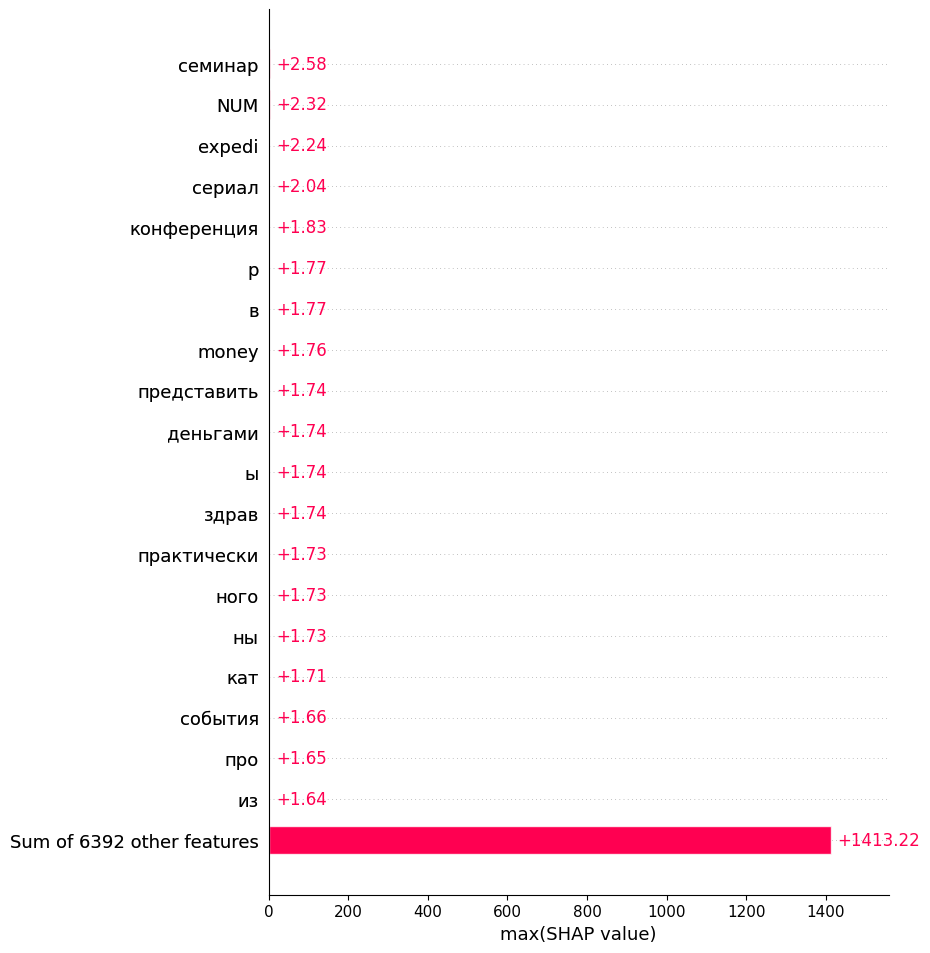

In [ ]:

shap.plots.bar(shap_values[:,:, 1].max(axis=0), max_display=20,
               order=shap.Explanation.argsort.flip)

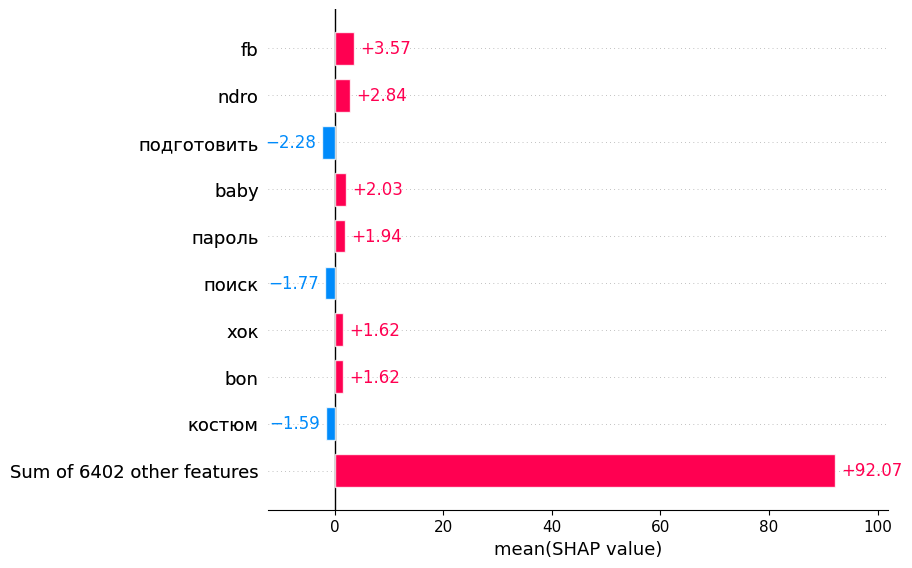

In [ ]:
shap.plots.bar(shap_values[:,:,0].mean(0)) # по классу 0

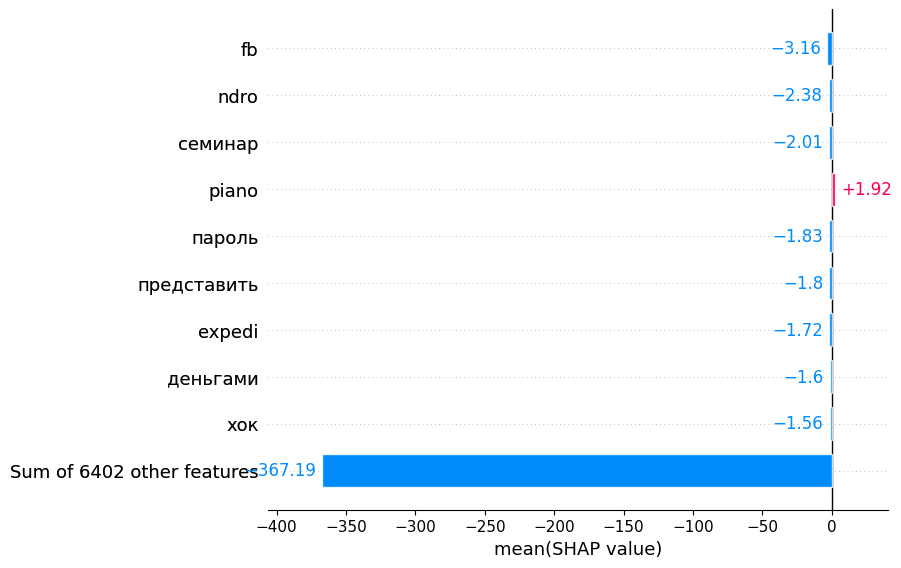

In [ ]:
shap.plots.bar(shap_values[:,:,2].mean(0)) 

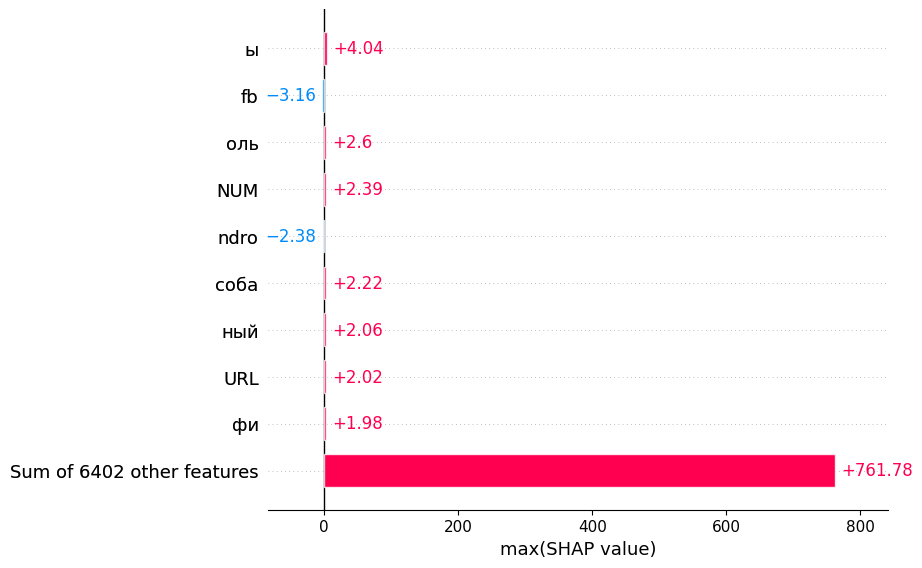

In [ ]:
shap.plots.bar(shap_values[:,:,2].max(0)) 

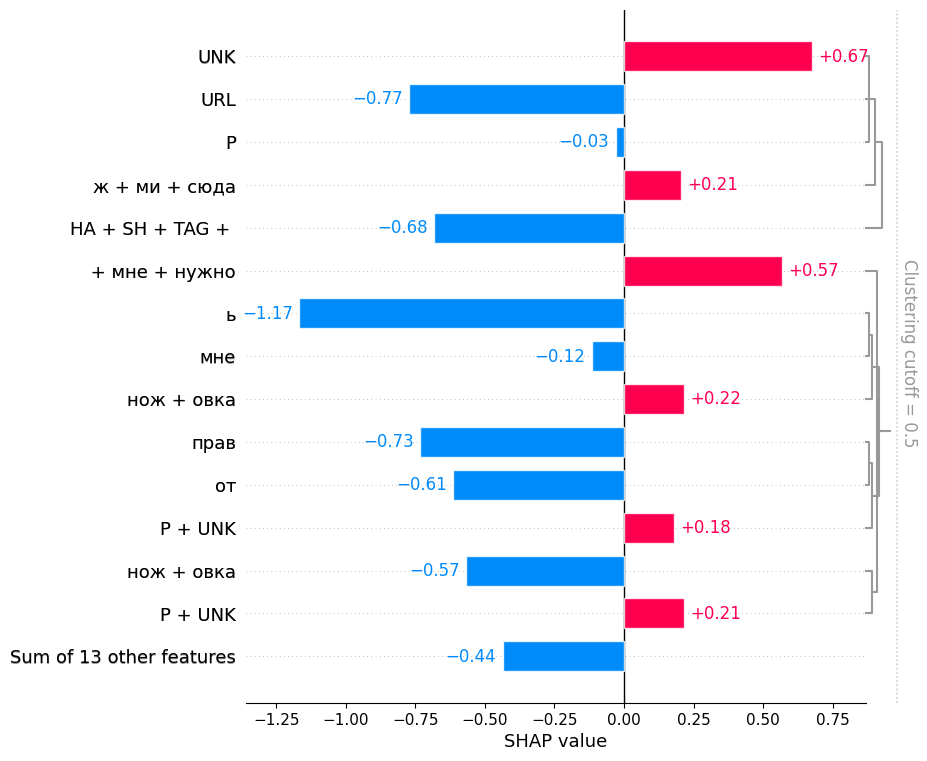

In [ ]:
shap.plots.bar(shap_values[2,:, 2], max_display=15,
               order=shap.Explanation.argsort.flip)

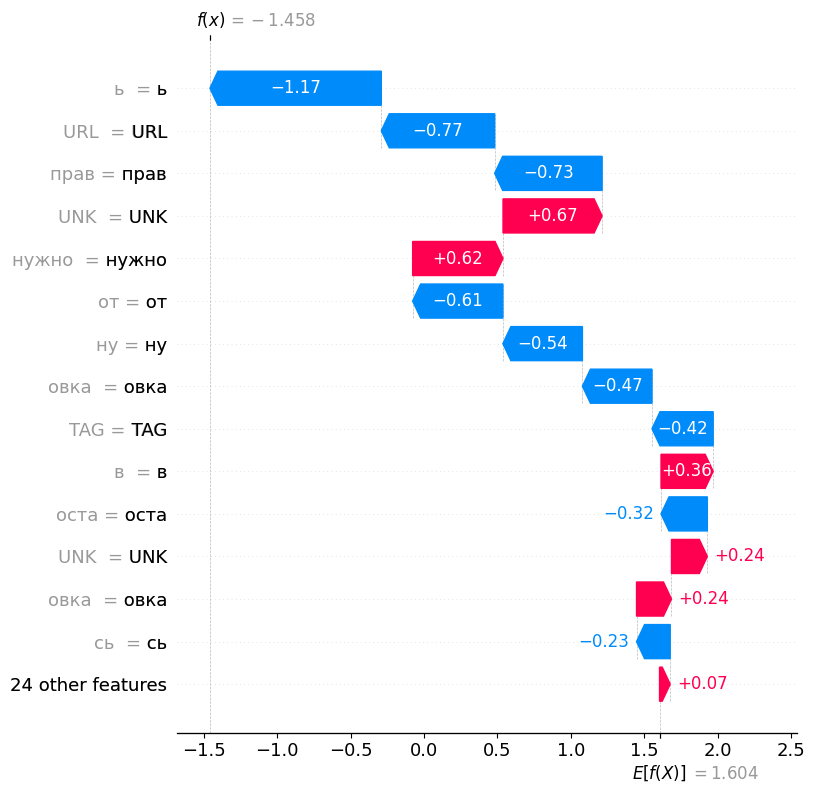

In [ ]:
shap.waterfall_plot(shap_values[2][:, 2], max_display=15)